# Cohort Case Study 2

In [24]:
import sys
sys.path.append('../../../notebooks')

import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from raimitigations.utils import split_data, fetch_cohort_results
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager
from download import download_datasets

SEED = 46
#SEED = None

np.random.seed(SEED)
random.seed(SEED)

data_dir = "../../../datasets/census/"
download_datasets(data_dir)

label_col = "income"
df_train = pd.read_csv(data_dir + "train.csv")
df_test = pd.read_csv(data_dir + "test.csv")
# convert to 0 and 1 encoding
df_train[label_col] = df_train[label_col].apply(lambda x: 0 if x == "<=50K" else 1)
df_test[label_col] = df_test[label_col].apply(lambda x: 0 if x == "<=50K" else 1)

X_train = df_train.drop(columns=[label_col])
y_train = df_train[label_col]
X_test = df_test.drop(columns=[label_col])
y_test = df_test[label_col]

In [25]:
print(df_train.shape)
print(df_test.shape)

(32561, 15)
(16281, 15)


In [26]:
df_train

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,0,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,0,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,1,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,0,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,0,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [27]:
def get_model():
    model = LGBMClassifier(random_state=SEED)
    #model = LogisticRegression()
    return model

In [28]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["race"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.928045,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`race` == "" Amer-Indian-Eskimo"")",159,0.964286,0.760706,0.916541,0.807547,0.893082
2,cohort_1,"(`race` == "" Asian-Pac-Islander"")",480,0.904596,0.777669,0.830903,0.789716,0.812500
3,cohort_2,"(`race` == "" Black"")",1561,0.950497,0.706862,0.886423,0.744534,0.846252
4,cohort_3,"(`race` == "" Other"")",135,0.980000,0.895238,0.952727,0.920085,0.948148
5,cohort_4,"(`race` == "" White"")",13946,0.924495,0.776855,0.840369,0.793715,0.824896


In [29]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.928045,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`gender` == "" Female"")",5421,0.945489,0.697068,0.866671,0.734840,0.848552
2,cohort_1,"(`gender` == "" Male"")",10860,0.910614,0.780929,0.821125,0.790895,0.809761


In [30]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.928045,0.774041,0.846508,0.793006,0.828082
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.851455,0.767644,0.760808,0.762712,0.767745
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.903658,0.648626,0.823863,0.672058,0.806685
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.936405,0.574932,0.890196,0.588954,0.849524
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.933263,0.545761,0.884905,0.540163,0.839634
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.908060,0.597355,0.833168,0.610507,0.811793
6,cohort_5,"(`relationship` == "" Wife"")",763,0.873899,0.792793,0.794374,0.793273,0.794233


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1) 
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

## A Closer Look at the "gender" cohorts

0    24720
1     7841
Name: income, dtype: int64

cohort_0:
0    9592
1    1179
Name: income, dtype: int64
***********

cohort_1:
0    15128
1     6662
Name: income, dtype: int64
***********


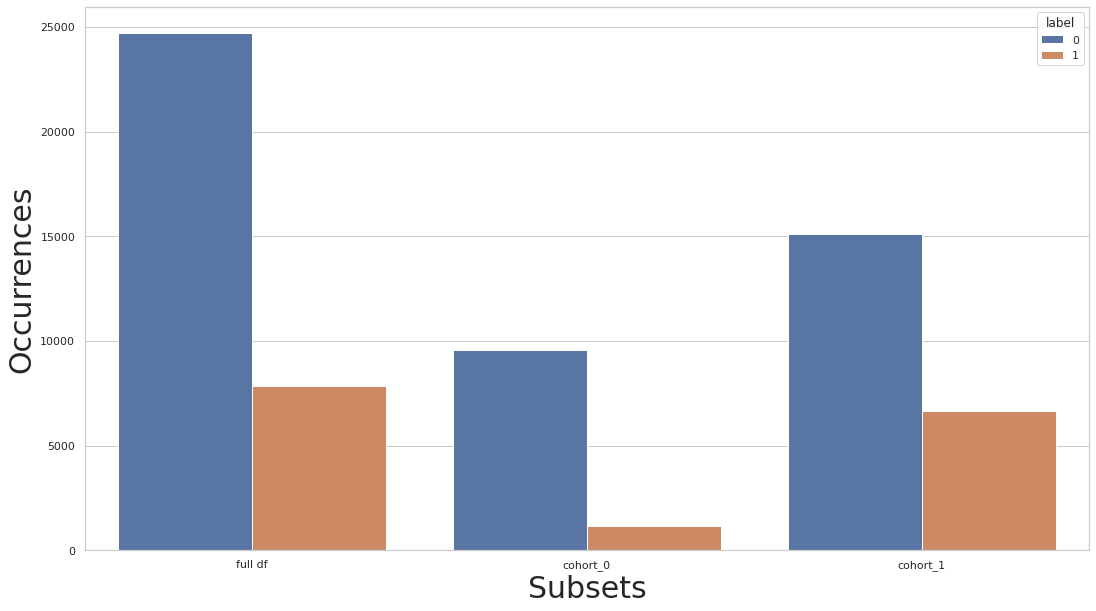

In [32]:
cohort_set = CohortManager(
    cohort_col=["gender"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

0    24720
1    24720
Name: income, dtype: int64

cohort_0:
0    9592
1    2101
Name: income, dtype: int64
***********

cohort_1:
1    22619
0    15128
Name: income, dtype: int64
***********


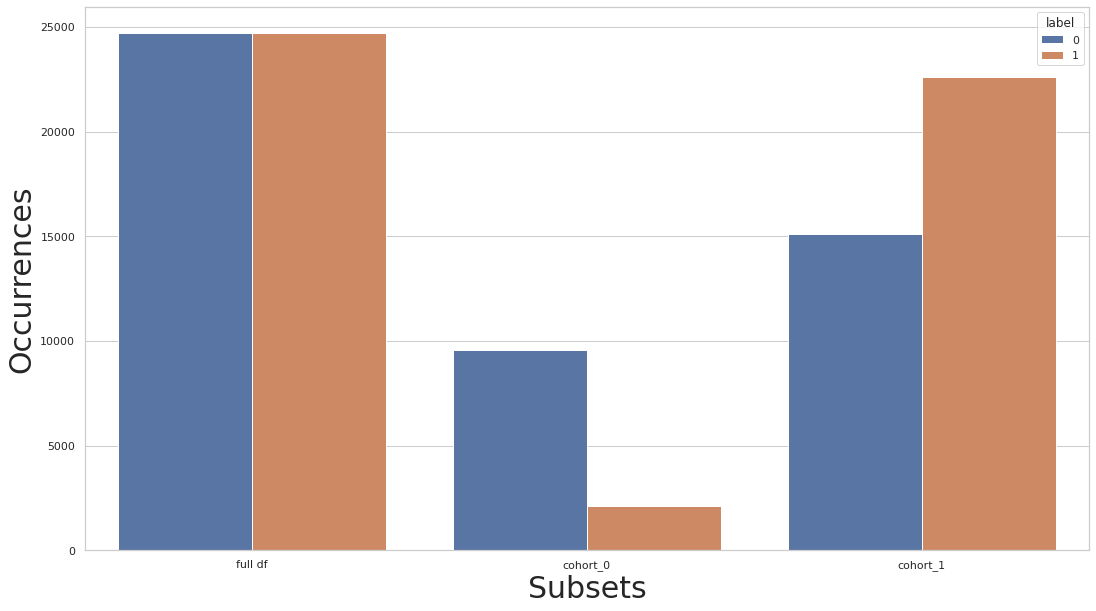

In [33]:
rebalance = dp.Rebalance(verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set = CohortManager(cohort_col=["gender"])
cohort_set.fit(X=new_X_train, y=new_y_train)
subsets = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

print(new_y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [34]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.921874,0.765679,0.836890,0.783717,0.819974
1,cohort_0,"(`gender` == "" Female"")",5421,0.943926,0.728142,0.871062,0.770988,0.881572
2,cohort_1,"(`gender` == "" Male"")",10860,0.901664,0.783273,0.814115,0.793634,0.816298


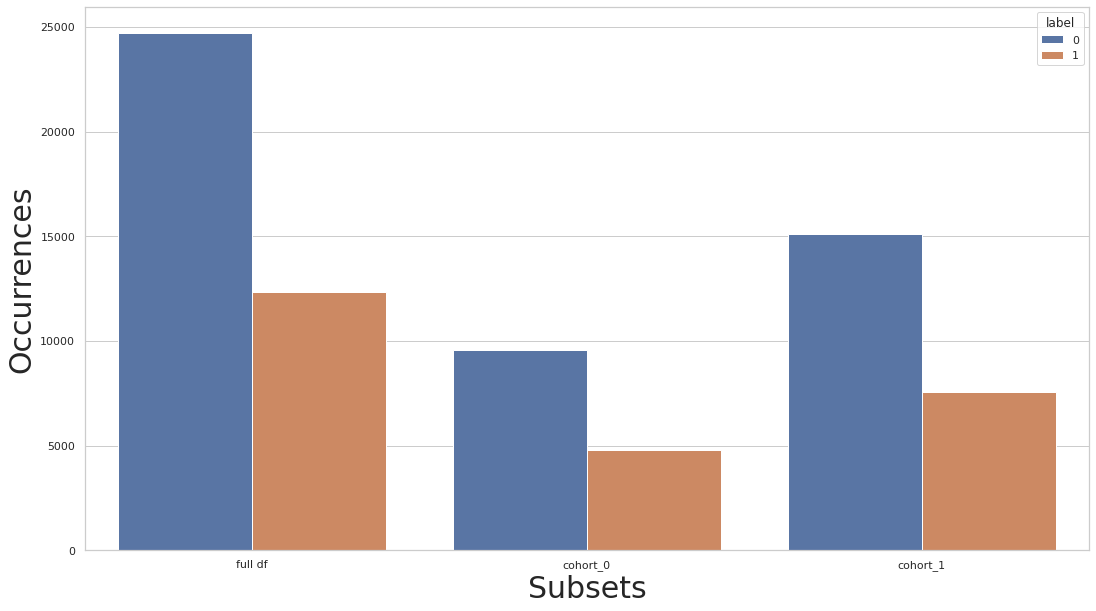

In [35]:
c0_pipe = [dp.Rebalance(strategy_over=0.5, verbose=False)]
c1_pipe = [dp.Rebalance(strategy_over=0.5, verbose=False)]

rebalance_cohort = CohortManager(
    transform_pipe=[c0_pipe, c1_pipe],
    cohort_col=["gender"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [36]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.923905,0.782387,0.840922,0.801737,0.840673
1,cohort_0,"(`gender` == "" Female"")",5421,0.942316,0.735779,0.865427,0.777674,0.888766
2,cohort_1,"(`gender` == "" Male"")",10860,0.907742,0.784540,0.819998,0.795202,0.815930


In [37]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["gender"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.923656,0.771099,0.840483,0.789942,0.826423
1,cohort_0,"(`gender` == "" Female"")",5421,0.937167,0.698234,0.863015,0.736438,0.851319
2,cohort_1,"(`gender` == "" Male"")",10860,0.908443,0.779013,0.819349,0.788785,0.807643


In [38]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["gender"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["gender"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.924731,0.771722,0.841294,0.790623,0.826976
1,cohort_0,"(`gender` == "" Female"")",5421,0.939232,0.726703,0.867672,0.769103,0.880834
2,cohort_1,"(`gender` == "" Male"")",10860,0.908182,0.784077,0.818615,0.794710,0.815838


## A Closer Look at the "relationship" cohorts

0    24720
1     7841
Name: income, dtype: int64

cohort_0:
0    7275
1    5918
Name: income, dtype: int64
***********

cohort_1:
0    7449
1     856
Name: income, dtype: int64
***********

cohort_2:
0    944
1     37
Name: income, dtype: int64
***********

cohort_3:
0    5001
1      67
Name: income, dtype: int64
***********

cohort_4:
0    3228
1     218
Name: income, dtype: int64
***********

cohort_5:
0    823
1    745
Name: income, dtype: int64
***********


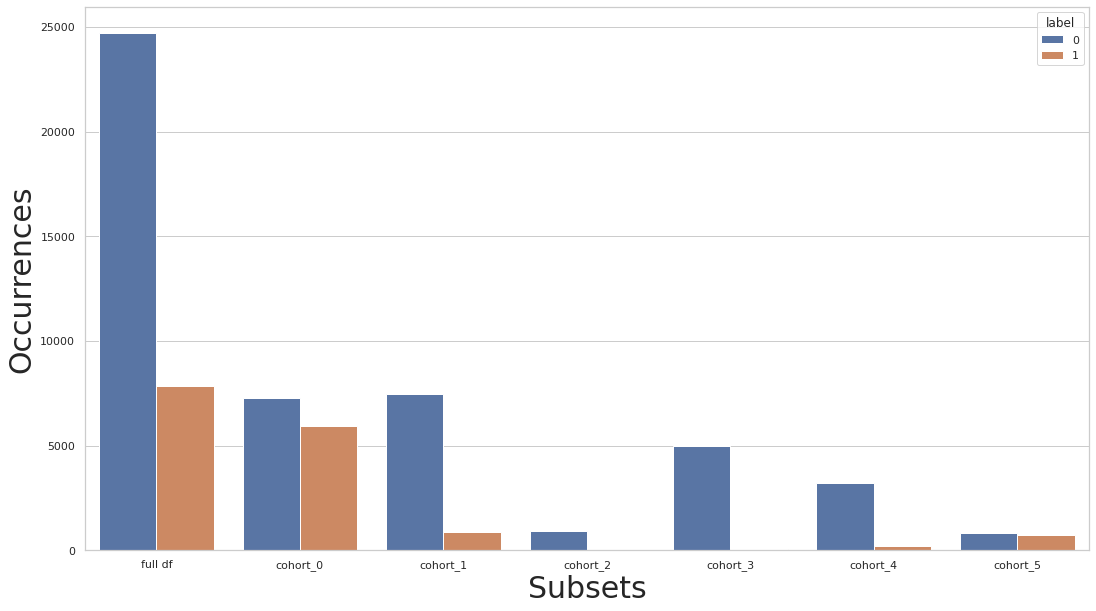

In [39]:
cohort_set = CohortManager(
    cohort_col=["relationship"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

0    24720
1    24720
Name: income, dtype: int64

cohort_0:
1    21542
0     7275
Name: income, dtype: int64
***********

cohort_1:
0    7449
1    1439
Name: income, dtype: int64
***********

cohort_2:
0    944
1     39
Name: income, dtype: int64
***********

cohort_3:
0    5001
1      86
Name: income, dtype: int64
***********

cohort_4:
0    3228
1     244
Name: income, dtype: int64
***********

cohort_5:
1    1370
0     823
Name: income, dtype: int64
***********


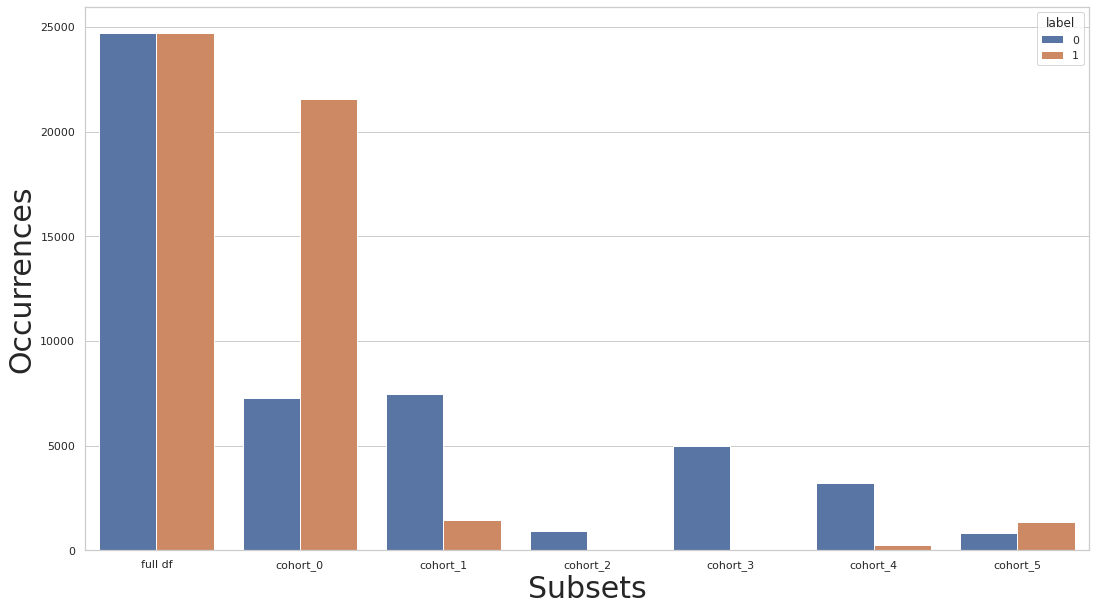

In [40]:
rebalance = dp.Rebalance(verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set.fit(X=new_X_train, y=new_y_train)
subsets = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

print(new_y_train.value_counts())
for key in subsets.keys():
    print(f"\n{key}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [41]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.921685,0.779142,0.837784,0.798306,0.837664
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.834405,0.745992,0.747935,0.746473,0.747969
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.901131,0.685957,0.826324,0.723744,0.862786
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.956471,0.592222,0.906863,0.623264,0.881905
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.931252,0.550008,0.873923,0.554056,0.861918
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.897542,0.593959,0.821550,0.605577,0.809410
6,cohort_5,"(`relationship` == "" Wife"")",763,0.864070,0.791314,0.791314,0.791314,0.792923


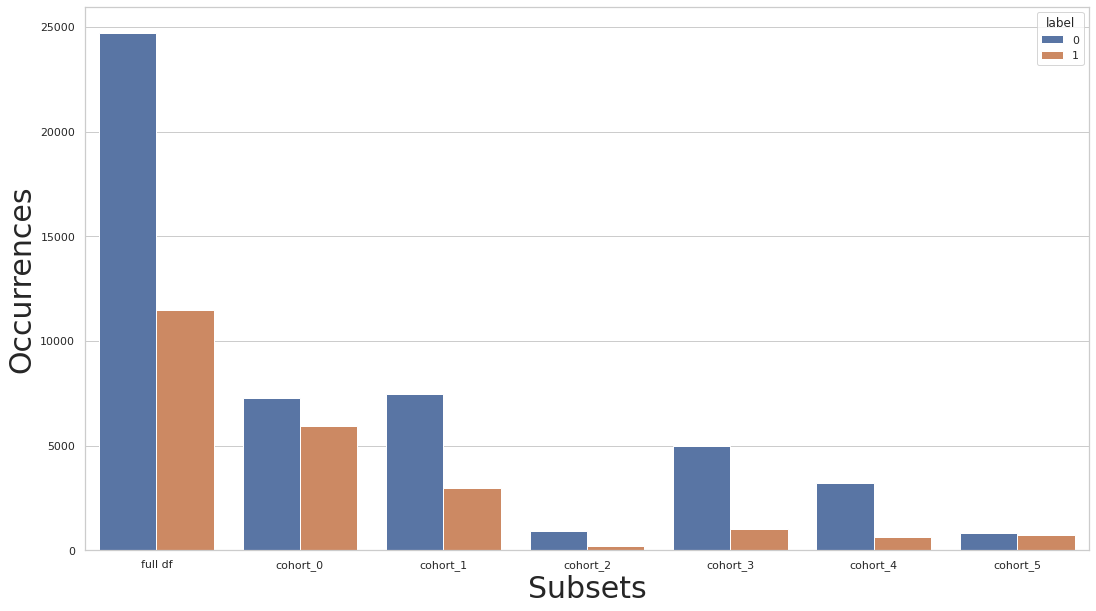

In [42]:
c0_pipe = []
c1_pipe = [dp.Rebalance(strategy_over=0.4, verbose=False)]
c2_pipe = [dp.Rebalance(strategy_over=0.2, verbose=False)]
c3_pipe = [dp.Rebalance(strategy_over=0.2, verbose=False)]
c4_pipe = [dp.Rebalance(strategy_over=0.2, verbose=False)]
c5_pipe = []

rebalance_cohort = CohortManager(
    transform_pipe=[c0_pipe, c1_pipe, c2_pipe, c3_pipe, c4_pipe, c5_pipe],
    cohort_col=["relationship"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train, new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

In [43]:
pipe = Pipeline([
            ("scaler", dp.DataStandardScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.918294,0.768412,0.835267,0.787073,0.824765
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.847737,0.759599,0.759083,0.759325,0.762073
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.897001,0.682007,0.821456,0.718938,0.859748
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.939216,0.608024,0.888235,0.651086,0.908571
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.916768,0.541246,0.849396,0.532195,0.835655
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.906317,0.611168,0.826477,0.638927,0.848124
6,cohort_5,"(`relationship` == "" Wife"")",763,0.874643,0.795250,0.789039,0.790782,0.794233


In [44]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.921740,0.774480,0.838504,0.793696,0.831767
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.847310,0.768719,0.761313,0.763310,0.768511
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.894365,0.652406,0.815078,0.679824,0.819542
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.904314,0.574198,0.862745,0.591053,0.859048
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.872706,0.603854,0.799634,0.629067,0.846337
6,cohort_5,"(`relationship` == "" Wife"")",763,0.830681,0.749464,0.751278,0.748091,0.748362


### "relationship" == "Own-child"

In [45]:
c0 = [ ['relationship', '==', [' Own-child']] ]
c1 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.926455,0.774861,0.844373,0.794105,0.830170
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.851043,0.771036,0.760570,0.762947,0.769125
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.904380,0.663575,0.820838,0.695773,0.835671
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.956732,0.573529,0.914706,0.581581,0.834286
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.907919,0.606513,0.826619,0.630507,0.838594
6,cohort_5,"(`relationship` == "" Wife"")",763,0.871434,0.800143,0.797383,0.798401,0.800786


In [46]:
c0 = [ ['relationship', '==', [' Own-child']] ]
c1 = [ ['relationship', '==', [' Not-in-family', ' Unmarried']] ]
c2 = None

cht_manager = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_def=[c0, c1, c2]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"])

,cohort,cht_query,cht_size,roc,pr,recall,f1,acc
0,all,all,16281,0.925274,0.778632,0.842644,0.798186,0.835759
1,cohort_0,"(`relationship` == "" Husband"")",6523,0.848288,0.760762,0.759740,0.760192,0.763146
2,cohort_1,"(`relationship` == "" Not-in-family"")",4278,0.903614,0.662846,0.824587,0.694509,0.832866
3,cohort_2,"(`relationship` == "" Other-relative"")",525,0.907974,0.614483,0.861765,0.660477,0.920000
4,cohort_3,"(`relationship` == "" Own-child"")",2513,0.908999,0.600146,0.849079,0.646560,0.944688
5,cohort_4,"(`relationship` == "" Unmarried"")",1679,0.903362,0.598105,0.818432,0.615314,0.823109
6,cohort_5,"(`relationship` == "" Wife"")",763,0.876226,0.794176,0.796462,0.793824,0.794233
